<a href="https://colab.research.google.com/github/gbessardon/r-capstone-project/blob/main/Capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study: Howdoesabike-share navigate speedy success?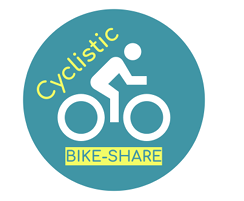

For this capstone project I am in a scenario where I need to analyse the data from a bike share company cyclistic that would like to convert casual members into annual members.
For this the company needs to understand how the casual members differ from annual members and that is the question I am aiming to reply here.

## STEP 0: IMPORT LIBRARIES

In [1]:
library(tidyverse)  #helps wrangle data
# Use the conflicted package to manage conflicts
library(conflicted)
library(curl)

# Set dplyr::filter and dplyr::lag as the default choices
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Using libcurl 7.81.0 with OpenSSL/3.0.2

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::lag over any other package.


# STEP 1: DOWNLOAD DATA


In [ ]:
# List of URLs for the zip files
zip_urls <- c(
  "https://divvy-tripdata.s3.amazonaws.com/202303-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202304-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202305-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202306-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202307-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202308-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202309-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202310-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202311-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202312-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202401-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202402-divvy-tripdata.zip",
  "https://divvy-tripdata.s3.amazonaws.com/202403-divvy-tripdata.zip"

)

# Create a function to download and extract a zip file
download_and_extract <- function(url) {
  # Create the csv_file
  extracted_file <- gsub(".*/(\\d{6}-divvy-tripdata)\\.zip", "\\1.csv", url)
  if (file.exists(extracted_file)) {
    print("The file exists!")
    data <- read.table(extracted_file, sep = ",", header = TRUE)
    }
    else {
      print("The file does not exist.")
      # Create a temporary file to store the downloaded zip file
      temp_file <- tempfile()
      # Download the zip file
      download.file(url, temp_file, mode = "wb")
      # Extract the target file from the zip archive
      data <- read.table(unz(temp_file, extracted_file), sep = ",", header = TRUE)
      write.csv(data, file = extracted_file, row.names = FALSE)
      # Clean up: remove the temporary file
      unlink(temp_file)
      }
  # Return the extracted data
  return(data)
}

# Initialize an empty list to store the extracted data frames
all_data <- list()

# Loop through the URLs and download/extract data
for (url in zip_urls) {
  extracted_data <- download_and_extract(url)
  all_data[[length(all_data) + 1]] <- extracted_data
}

[1] "The file does not exist."
[1] "The file does not exist."


In [ ]:
for (i in seq_along(all_data)) {
  cat("Table", i, "column names:\n")
  print(colnames(all_data[[i]]))
  cat("\n")
}

In [ ]:
# Stack individual quarter's data frames into one big data frame
all_trips<-bind_rows(all_data)

# STEP 2: CLEAN UP AND ADD DATA TO PREPARE FOR ANALYSIS

## Inspect the new table that has been created

In [ ]:

colnames(all_trips)  #List of column names
nrow(all_trips)  #How many rows are in data frame?
dim(all_trips)  #Dimensions of the data frame?
head(all_trips)  #See the first 6 rows of data frame.
tail(all_trips)  #See the last 6 rows of data frame.
str(all_trips)  #See list of columns and data types (numeric, character, etc)
summary(all_trips)  #Statistical summary of data. Mainly for numerics


### In some of the project documentation there were issues with unconsistencies in the member name so I use the function unique to look at the column values

In [ ]:
unique(all_trips$member_casual)

Only two values appears which is correct

### I look at station names according to the project documentation some ride appear as "HQ QR" let's look at all the station list

In [ ]:
sort(unique(all_trips$start_station_name))

The list of unique values is very long so I should look at the number of rows with "HQ QR"


In [ ]:
all_trips[all_trips$start_station_name == "HQ QR",]

Good news there are no HQ QR values

## Add columns that list the date, month, day, and year of each ride
* This will allow us to aggregate ride data for each month, day, or year ... before completing these operations we could only aggregate at the ride level
* https://www.statmethods.net/input/dates.html more on date formats in R found at that link

In [ ]:
all_trips$date <- as.Date(all_trips$started_at) #The default format is yyyy-mm-dd
all_trips$month <- format(as.Date(all_trips$date), "%m")
all_trips$day <- format(as.Date(all_trips$date), "%d")
all_trips$year <- format(as.Date(all_trips$date), "%Y")
all_trips$day_of_week <- format(as.Date(all_trips$date), "%A")

## Create a trip duration column

In [ ]:
# I use the difftime function to calculate the trip duration
all_trips$duration <- difftime(all_trips$ended_at,all_trips$started_at)
all_trips$duration <- as.numeric(as.character(all_trips$duration))

 I check if there are issues in the trip

In [ ]:
maxduration <- max(all_trips$duration)
print(maxduration)

The maximum value is quite high let's see that row

In [ ]:
all_trips[all_trips$duration == maxduration,]

I can see that the trip was never ended so I need to remove the trip with no end_station_name	end_station_id	 end_lat end_lon

In [ ]:
min(all_trips$duration)

Minimum values are negative so negative value need to be removed

### Create a return ride column

In [ ]:
all_trips$return_ride <- all_trips$start_station_id==all_trips$end_station_id

## I create a new version of the dataframe (v2) removing negative duration and unfinished trips
https://www.datasciencemadesimple.com/delete-or-drop-rows-in-r-with-conditions-2/


In [ ]:
all_trips_v2<- all_trips[!(all_trips$end_station_name == "" | all_trips$duration<0),]


# STEP 3:  DESCRIPTIVE ANALYSIS
Now the data is clean I can describe the data

## Descriptive analysis on duration (all figures in seconds)

In [ ]:
summary(all_trips_v2$duration)

### Comparison between members and casual users

In [ ]:
aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual, FUN = mean)
aggregate(all_trips_v2$duration~ all_trips_v2$member_casual, FUN = median)
aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual, FUN = max)
aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual, FUN = min)

Casual riders have generally longer trips than the members

### See the average ride duration by each day for members vs casual users

In [ ]:
aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual + all_trips_v2$day_of_week,
FUN = mean)

Let's reorder the days of the week

In [ ]:
all_trips_v2$day_of_week <- ordered(all_trips_v2$day_of_week, levels=c("Sunday", "Monday",
"Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))

Let's plot the ordered results

In [ ]:
aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual + all_trips_v2$day_of_week,
FUN = mean)

Casual members are having longer rides in average each day of the week

## analyze ridership data by rider type and weekday


In [ ]:
all_trips_v2 %>%
  mutate(weekday = wday(started_at, label = TRUE)) %>% #creates weekday field using wday()
  group_by(member_casual, weekday) %>% #groups by usertype and weekday
  summarise(number_of_rides = n() #calculates the number of rides and average duration
            ,average_duration = mean(duration)) %>% # calculates the average duration
  arrange(member_casual, weekday) # sorts

### Let's visualize the number of rides by rider type

In [ ]:
all_trips_v2 %>%
  mutate(weekday = wday(started_at, label = TRUE)) %>%
  group_by(member_casual, weekday) %>%
  summarise(number_of_rides = n()
            ,average_duration = mean(duration)) %>%
  arrange(member_casual, weekday) %>%
  ggplot(aes(x = weekday, y = number_of_rides, fill = member_casual)) +
  geom_col(position = "dodge")

we can see a clear increase in the casual member bike usage over the weekend

## analyze ridership data by rider type and rideable type

In [ ]:
all_trips_v2 %>%
  group_by(member_casual, rideable_type) %>% #groups by usertype and rideable_type
  summarise(number_of_rides = n() #calculates the number of rides and average duration
            ,average_duration = mean(duration)) %>% # calculates the average duration
  arrange(member_casual, rideable_type) # sorts

### Let's visualize the number of rides by rider type

In [ ]:
all_trips_v2 %>%
  group_by(member_casual, rideable_type) %>% #groups by usertype and rideable_type
  summarise(number_of_rides = n()
            ,average_duration = mean(duration)) %>%
  arrange(member_casual, rideable_type) %>%
  ggplot(aes(x = rideable_type, y = number_of_rides,
 fill = member_casual)) +
  geom_col(position = "dodge")

Only casual member use docked bikes otherwise, the rideable_type distribution between classic_bike and electric_bike seems independent of membership type

## analyze ridership data by rider type and retrun ride

In [ ]:
all_trips_v2 %>%
  group_by(member_casual, return_ride) %>% #groups by usertype and rideable_type
  summarise(number_of_rides = n()
            ,average_duration = mean(duration)) %>%
  arrange(member_casual, return_ride) %>%
  ggplot(aes(x = member_casual, y = number_of_rides,
 fill = return_ride)) +
geom_col(position = "dodge")

Memebers and casual rider rarely return their bikes at the same station

# STEP 4: EXPORT SUMMARY FILE FOR FURTHER ANALYSIS

In [ ]:
# Create a csv file that we will visualize in Excel, Tableau, or my presentation software
# N.B.: This file location is for a Mac. If you are working on a PC, change the file location accordingly (most likely "C:\Users\YOUR_USERNAME\Desktop\...") to export the data. You can read more here: https://datatofish.com/export-dataframe-to-csv-in-r/
counts <- aggregate(all_trips_v2$duration ~ all_trips_v2$member_casual + all_trips_v2$day_of_week + all_trips_v2$rideable_type + all_trips_v2$return_ride + all_trips_v2$start_lat + all_trips_v2$start_lng+ all_trips_v2$end_lat + all_trips_v2$end_lng +all_trips_v2$all_trips$date, FUN = mean)
write.csv(counts, file = 'avg_ride_length.csv')
